In [1]:
from typing import TypedDict, Annotated, List, Literal, Optional, cast
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.messages.base import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.runnables.config import RunnableConfig

from pathlib import Path
from pydantic import Field
from pydantic_settings import BaseSettings, SettingsConfigDict

import logging 

def logs(file_name: str):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)

    # Avoid adding handlers multiple times
    if not logger.handlers:
        console_handler = logging.StreamHandler()
        file_handler = logging.FileHandler(file_name, mode="a", encoding="utf-8")
        formatter = logging.Formatter(
            "{asctime} - {levelname} - {message}",
            style="{",
            datefmt="%Y-%m-%d %H:%M"
        )

        console_handler.setFormatter(formatter)
        console_handler.setLevel(logging.DEBUG)
        file_handler.setLevel(logging.DEBUG)

        logger.addHandler(console_handler)
        logger.addHandler(file_handler)

    return logger

logger = logs("main.log")

d:\medicare\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class Settings(BaseSettings):
    model_config = SettingsConfigDict()

    # ----------------------------------- RAG configuration ------------------------------------------------
    # --- Embedding Configuration ---
    EMBEDDING_MODEL_NAME: str = "all-MiniLM-L6-v2"

    # --- GROQ Configuration ---
    GROQ_API_KEY: str = ""
    GROQ_LLM_MODEL: str = "qwen/qwen3-32b"

    # --- LANGCHAIN & RELATED Configuration ---
    TAVILY_API_KEY: str = ""

settings = Settings()

In [3]:
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing import List, Literal
import json
import os

reception_prompt_template = """
                                TASK:
                                Using the inputs, manage the patient interaction to locate records, gather necessary details,
                                surface non-clinical follow-ups, and escalate clinical questions to the clinical team. Act only on information available
                                in the provided discharge_report_content; do not invent clinical facts.
                                
                                TOOLS (available to call):
                                - database_retriever_tool(patient_name: str) -> returns a patient's discharge report text (use when discharge_report_content is empty or a fresh copy is required).

                                RULES (follow exactly):
                                1. If discharge_report_content is empty, ask for the patient’s full name to look up records. Then acknowledge the lookup ("Let me pull your report") before calling database_retriever_tool(patient_name).
                                2. When discharge_report_content is provided, treat it as the single source of truth for any retrieval-based statements. Quote or paraphrase only what appears there.
                                3. Always ask short, focused, open questions about recovery, medication-taking, symptom changes, wound status, appointment needs, or other non-clinical logistics related to the report.
                                4. If the patient’s query clearly requests clinical management (diagnosis, medication dosing or changes, new/worsening symptoms, or treatment decisions), do NOT provide clinical advice. Instead:
                                - Summarize the clinical question in one concise sentence (include key context from discharge_report_content, e.g., medication name, dates, or relevant findings).
                                - Tell the patient you will escalate this to clinical staff and ask if they have other concerns.
                                5. If the patient reports emergency/red-flag symptoms (e.g., severe chest pain, trouble breathing, heavy bleeding, sudden confusion), instruct immediate emergency care AND call route_to_clinical_agent with a clear, urgent summary.
                                6. Never include identifiable patient data (PHI) in free-text logs or outputs; use de-identified IDs when logging or noting records.
                                7. Maintain a polite, empathetic, professional voice and keep replies short and easy to understand.

                                PREFERRED WORKFLOW (stepwise):
                                1. No discharge_report_content:
                                - Ask for the patient's full name.
                                - After they reply, say a brief confirmation that you will retrieve the record, then call database_retriever_tool(name).
                                2. Report present:
                                - Begin with a one-sentence synthesis of the key items you can see (discharge date, reason for admission, major meds or follow-up instructions) — only if those items are in discharge_report_content.
                                - Ask 1–2 targeted, non-clinical follow-up questions (medication adherence, pain level, wound appearance, appointment scheduling).
                                3. Clinical question detected:
                                - Produce a single-sentence clinical summary (include the minimal necessary context from the report).
                                - Inform the patient that the clinical team will review and ask if they have additional concerns.

                                OUTPUT STYLE:
                                - Short, clear sentences (one or two per line).
                                - Patient-centered phrasing: ask about feelings, symptoms, ability to follow instructions.
                                - Before invoking any tool, state a one-line confirmation (e.g., "Let me pull up your report now.").
                                - Do not log PHI in visible text outputs; use redacted or de-identified placeholders if you must reference identity in internal notes.

                                SAFETY & BOUNDARIES:
                                - Do not provide medical recommendations, dosages, or clinical management.
                                - Escalate all clinical management requests to the clinical team via route_to_clinical_agent.
                                - For severe or life-threatening complaints, instruct immediate emergency care and flag clinical staff.

                                IMPLEMENTATION NOTES:
                                - Treat discharge_report_content as authoritative for facts about the patient’s care.
                                - If both query and discharge_report_content are present, weave only relevant details from the report into follow-ups and any handoff summary.
                                - Keep summaries and handoffs as brief as possible while preserving critical context (medication names, dates, symptoms, and any recent changes).

                                INPUT (substituted below):
                                Query:
                                \"\"\"{query}\"\"\"

                                Discharge report (if available):
                                \"\"\"{discharge_report_content}\"\"\"
"""

@tool
def database_retriever_tool(patient_name: str, file_path: str = r"D:\medicare\Data\reports.json") -> dict:
    """
    Read a JSON file of patient discharge reports and return the record(s) that match `patient_name`.

    Behavior:
    - `patient_name` is matched case-insensitively against the "patient_name" field in each record.
    - If an exact (case-insensitive) match is found, that entry is returned.
    - If no exact match, a fallback substring match is attempted (useful for partial names).
    - If multiple records match, returns a dict with key "matches" containing the list of matching entries.
    - On error or no matches, returns a dict with an "error" key describing the problem.
    """

    try:
        # validate input
        if not isinstance(patient_name, str) or not patient_name.strip():
            return {"error": "patient_name must be a non-empty string."}

        # check file exists
        if not os.path.exists(file_path):
            return {"error": f"File not found: {file_path}"}

        # load json
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # normalize to a list of records
        if isinstance(data, dict):
            # if top-level is a dict but contains a list under common keys, try to use it
            for candidate_key in ("reports", "patients", "records"):
                if candidate_key in data and isinstance(data[candidate_key], list):
                    data_list = data[candidate_key]
                    break
            else:
                # otherwise wrap single dict into list
                data_list = [data]
        elif isinstance(data, list):
            data_list = data
        else:
            return {"error": "Unexpected JSON structure: expected list or dict."}

        # normalize search name
        name_norm = patient_name.strip().lower()

        # exact (case-insensitive) matches
        exact_matches = [
            rec for rec in data_list
            if isinstance(rec, dict) and rec.get("patient_name", "").strip().lower() == name_norm
        ]

        if exact_matches:
            # return single entry if one, else return list under "matches"
            return {"match" : exact_matches[0]} if len(exact_matches) == 1 else {"matches": exact_matches}
        else:
            return {"error": f"No records found for patient name '{patient_name}'."}

    except Exception as e:
        return {"error": str(e)}

tools_reception = [database_retriever_tool]

decision_node_llm = ChatGroq(
    model=settings.GROQ_LLM_MODEL,
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    api_key=settings.GROQ_API_KEY,  # type: ignore
)

instance_decision_llm = decision_node_llm.bind_tools(tools=tools_reception)

In [4]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from typing import Union
import traceback

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    user_inputs: Annotated[List[HumanMessage], add_messages]

def reception_node(state: AgentState):     #[Humanmessage - > AIMessage -> ToolMessage -> AIMessage -> HumanMessage -> next agent]
    try:
        query = next(
                (m for m in state["user_inputs"] if isinstance(m, HumanMessage)),
                None
        )

        if query is None:
            raise ValueError("No message in state")
        
        has_tool_message = any(isinstance(m, ToolMessage) and m.name=='database_retriever_tool' for m in state["messages"])
        if has_tool_message:
            print(f"data_retrieval_tool message was found {state['messages']}")
            data_tool_message = next(
                (m for m in state["messages"] if isinstance(m, ToolMessage) and m.name == 'database_retriever_tool'),
                None
            )
            if data_tool_message is None:
                logger.warning("The agent didnt call the data_retriever_tool for fetching reports!!")
            else:
                system_prompt = PromptTemplate(
                input_variables=["query", "discharge_report_content"],
                template=reception_prompt_template,
                )
                final_system_template = system_prompt.invoke(
                {"query": query.content, "discharge_report_content": data_tool_message.content}
                )
                
                question_patient = instance_decision_llm.invoke(final_system_template)
                            
                print(f"tool message llm questions : {question_patient}")
                print(f"full state messages till now : {state['messages']}")

                return {"messages" : [question_patient]}
            
        # extract query text
        query_text = query.content if isinstance(query.content, str) else str(query.content)
        system_prompt = PromptTemplate(
            input_variables=["query", "discharge_report_content"],
            template=reception_prompt_template,
        )
        final_system_template = system_prompt.invoke(
            {"query": query_text, "discharge_report_content": ""}
        )
        
        context_retriever_answer = instance_decision_llm.invoke(final_system_template)
        logger.info("decision maker llm was successfully invoked")
        
        if isinstance(context_retriever_answer, AIMessage):
            print("AIMessage content:", context_retriever_answer)
        else:
            print("Received non-AIMessage response;", repr(context_retriever_answer))

        print(f"final system template : {final_system_template}")
        print(f"test_new_template_reception : {state['messages']}")
        return {"messages" : [context_retriever_answer]}
    
    except Exception as e:
        logger.exception("decision maker node can't be executed: %s", e)
        print(traceback.format_exc())

In [5]:
#make tool node whicb needs to be connected to reception node so that it can receive the output of tool and then ask questions to user.
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools_reception)

In [6]:
clinical_llm_template = """
                            You are a clinical AI assistant specialized in nephrology. Use the instructions below to produce a single, evidence-based response to the user's question(s).
                            Throughout the prompt we will refer to: the retrieved RAG data (a local book/source), the web search results, the curated passages chosen for reasoning, and the user's query.
                            These input placeholders are defined once below and should be filled by your system before rendering this template.

                            IMPORTANT NOTE ABOUT THE RAG TOOL
                            - The RAG data tool does NOT contain personal user records or user-identifying information.
                            - Instead, the RAG datasource is a book-like source (textbook/ebook) that contains domain knowledge (chapters, sections, passages, and reference ids).
                            - Before creating the final answer, the system MUST produce a 1–2 line summary (source_summary) that describes the main topics and types of information contained in that source.

                            TOOLS (available)
                            - get_rag_data_tool(query: str) -> returns zero or more passages from the local RAG datasource (each passage may include a reference id, chapter, page, and a short evidence snippet).
                            - web_search_tool(query: str, max_results: int = 5) -> performs an external literature/web search and returns ranked results with short snippets. (Only use when RAG-derived information is missing or insufficient.)

                            INPUT_PLACEHOLDERS (fill these exactly once before rendering the template)
                            - retrieved_rag_data: {retrieved_rag_data}          # source_summary: Comprehensive Clinical Nephrology (7th ed.) is a single-volume clinical nephrology textbook that covers core renal science (anatomy, physiology), diagnostic methods (GFR, urinalysis, imaging, biopsy), and major disease areas including acute kidney injury, glomerular disease, diabetic kidney disease, hypertension, chronic kidney disease, dialysis modalities, and transplantation. It also provides practical, evidence-based guidance on drug dosing, interventional and critical-care nephrology, geriatric/palliative nephrology, and procedural techniques with extensive references and self-assessment material.  # 2-line summary produced from the uploaded RAG source (scanned).
                            - web_search_output: {web_search_output}            # (optional) web search results — present only if web_search_tool was called
                            - queries (the user's original question(s)): {queries}

                            PRINCIPLES (short)
                            1. Treat the RAG source (the textbook-like data) as a primary, authoritative local reference for nephrology content.
                        
                            a) Call the RAG tool first to retrieve passages from the local book/source.
                            b) Curate a small set of high-value passages from those retrieved RAG passages.
                            c) Only if the curated passages are empty or insufficient to answer the user's query, run the web search tool to supplement evidence.
                            
                            2. Do not invent facts — if information is missing or uncertain, say so and ask focused follow-ups.
                            3. Prioritize patient safety: avoid definitive therapeutic actions when critical information is missing; recommend clinician confirmation when appropriate.

                            HOW TO USE THE DATA
                            - "retrieved_rag_data" = raw RAG tool output (passages from the book-like source).
                            - Use web_search_tool only to fill gaps when the curated RAG passages do not answer the query.

                            OUTPUT STRUCTURE (produce these sections in order)
                            1) TL;DR — one-sentence summary (answer snapshot).
                            2) Answer — stepwise, teach-first then apply:
                            - One-line simple explanation of the core nephrology concept needed.
                            - Numbered clinical reasoning steps:
                                1. Assumptions made.
                                2. What was checked in the curated RAG passages (cite RAG reference ids).
                                3. What was checked in the web search results if used (list sources).
                                4. How the recommendation was reached.
                            - Separate evidence-based statements (with citations) and practical next steps.
                            - Quote exact lab values, units, ranges, or dosing ranges verbatim from the source and cite them.
                            4) Uncertainty & Confidence — short statement (High / Moderate / Low) with reason.
                            5) Follow-up Questions — up to 3 concise clinical clarifying questions.
                            6) Red Flags — immediate warning signs requiring urgent evaluation.
                            7) Patient-facing summary — 1–2 safe, simple sentences for the patient.
                            
                            PROCESSING STEPS (implementation checklist)
                            1) Call the RAG tool using the user's query and store its raw output as "retrieved_rag_data".
                            2) Produce a concise 1–2 line `source_summary` describing the book/source (topics, scope, editions/chapters referenced). Insert this into INPUT_PLACEHOLDERS before rendering the template.
                            3) Curate a small "curated passages" set internally from the retrieved_rag_data; this curated set is the primary evidence to consult during reasoning.
                            4) If the curated passages are empty or insufficient, call web_search_tool(query: str) and store results as "web_search_output". Use web sources only to supplement missing facts.
                            5) Produce the structured response (OUTPUT STRUCTURE), explicitly referencing passages from the curated RAG passages (by reference id) and any web sources used.
                            6) Log the raw retrieved_rag_data, source_summary, web_search_output (if any), curated passage ids, and the final LOG JSON object.
"""

from typing import Dict

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_huggingface import HuggingFaceEmbeddings
from typing import Optional

def load_embed_model(model_name: str = settings.EMBEDDING_MODEL_NAME):
    """
    Loads an embedding model from langchain hugging face module.
    Args :
        model_name(default = all-MiniLM-L6-v2)
    """

    embedding_model = HuggingFaceEmbeddings(model_name=model_name)
    logger.info("Embedding Model successfully loaded: %s", model_name)

    return embedding_model


def make_client(path: str = r"D:\medicare\src\infrastructure") -> QdrantClient:
    """Initialize and return a local Qdrant client."""
    try:
        client = QdrantClient(path=path)
        logger.info(f"Connected to Qdrant at {path}")
        return client
    except Exception as e:
        logger.error(f"Failed to create Qdrant client: {e}")
        raise


def get_collection(client: QdrantClient, collection_name: str = "Medicare"):
    """Return Qdrant collection metadata if it exists."""
    try:
        return client.get_collection(collection_name)
    except Exception as e:
        logger.warning(f"Collection '{collection_name}' not found or inaccessible: {e}")
        return None

def get_vector_store(
    client: QdrantClient,
    collection_name: str = "Medicare",
    embeddings: Optional[HuggingFaceEmbeddings] = None,
) -> QdrantVectorStore:
    """Create a QdrantVectorStore for similarity search."""
    if embeddings is None:
        embeddings = load_embed_model()
        logger.info("Loaded embedding model via load_embed_model()")

    try:
        vs = QdrantVectorStore(client=client, collection_name=collection_name, embedding=embeddings)
        logger.info(f"Vector store ready for collection '{collection_name}'")
        return vs
    except Exception as e:
        logger.error(f"Failed to initialize vector store: {e}")
        raise

@tool
def vector_retriever_tool(
    query: str,
    collection_name: str = "Medicare",
    top_k: int = 5,
    qdrant_path: str = r"D:\medicare\src\infrastructure",
) -> Union[Dict[str, List[Dict]], Dict[str, str]]:
    """
    Tool which can retrive data stored in a database 
    takes arguments as query. 
    returns relevant results
    
    """
    if not isinstance(query, str) or not query.strip():
        return {"error": "query must be a non-empty string."}

    try:
        client = make_client(path=qdrant_path)
        embeddings = load_embed_model()
        vs = get_vector_store(client=client, collection_name=collection_name, embeddings=embeddings)

        # single clear search call (keeps it simple)
        docs = vs.search(query, search_type="similarity", limit=top_k)

        matches = []
        for doc in docs:
            text = getattr(doc, "page_content", "") or ""
            meta = getattr(doc, "metadata", {}) or {}
            score = getattr(doc, "score", None)
            citation = meta.get("source") or meta.get("filename") or meta.get("doc_id") or "unknown"
            matches.append({"text": text, "score": score, "citation": citation, "metadata": meta})

        logger.info("Query=%r collection=%r returned %d matches", query, collection_name, len(matches))
        return {"matches": matches}

    except Exception as exc:
        logger.exception("Error in vector_retriever_tool: %s", exc)
        return {"error": str(exc)}

web_search_tool = TavilySearch(tavily_api_key=settings.TAVILY_API_KEY)

clinical_node_tools = [web_search_tool, vector_retriever_tool]

clinical_tool_node = ToolNode(clinical_node_tools)

clinical_llm = ChatGroq(
    model=settings.GROQ_LLM_MODEL,
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    api_key=settings.GROQ_API_KEY,  # type: ignore
).bind_tools(tools = clinical_node_tools)

In [7]:
def clinical_node(state: AgentState):
    try:
        print(f"all User_inputs till clinical_node {state['user_inputs']}")
        
        query = next(
            (m for m in reversed(state["user_inputs"]) if isinstance(m, HumanMessage)),
            None  # default if no HumanMessage found
        )
        
        logger.info("Entering clinical node")
        
        context_enhancer_prompt = PromptTemplate(
            input_variables=["queries", "retrieved_rag_data", "web_search_output"], template=clinical_llm_template
        )
        final_context_prompt = context_enhancer_prompt.invoke(
            {"queries": query.content, "retrieved_rag_data": "", "web_search_output": ""}
        )

        out = clinical_llm.invoke(final_context_prompt)
        logger.info("clinical llm output is : %s", out)
        return {"messages": [out]}
    except Exception as e:
        logger.exception("Couldn't execute context enhancer node %s", e)

In [8]:
def should_continue(state: AgentState) -> Literal["data", "next_agent"]:
    """Function to decide what to do next"""
    messages = state["messages"]
    last_message = messages[-1]
    print(f"the last message in should_continue is  : {last_message}")

    # Check if there's a ToolMessage named "data_retriever_tool"
    has_data_retriever_tool = any(
        isinstance(m, ToolMessage) and getattr(m, "name", None) == "data_retriever_tool"
        for m in messages
    )

    # Only check .tool_calls if the last message actually supports it
    if hasattr(last_message, "tool_calls") and last_message.tool_calls and not has_data_retriever_tool:
        print("ENTERING LOOP")
        return "data"
    else:
        return "next_agent"
    
# def should_continue_clinical(state: AgentState) -> Optional[Literal["clinical_tools", "exit"]]:
#     """Function to decide what to do next"""
#     messages = state["messages"]
#     last_message = messages[-1]
#     print(f"should continue states clinical : {state['messages']}")
#      # If the LLM makes a tool call, then perform an action
#     if last_message.tool_calls:
#         print("ENTERING web_search")
#         return "clinical_tools"
#     else:
#         return "exit"

def should_continue_clinical(state: AgentState) -> Optional[Literal["clinical_tools", "exit"]]:
    """Function to decide what to do next."""
    messages = state["messages"]
    last_message = messages[-1]
    print(f"should_continue states clinical : {state['messages']}")

    # If the last message is a ToolMessage, it means the tool has already executed
    if isinstance(last_message, ToolMessage):
        print("✅ Tool finished — returning to agent.")
        return "exit"

    # If the LLM just made a tool call, perform the tool action
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print("ENTERING web_search / clinical_tools")
        return "clinical_tools"

    # Otherwise, end or move to next stage
    return "exit"

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

returning output from clinical tools node!!


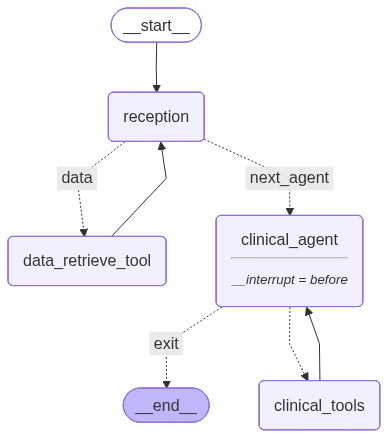

In [10]:
def graph():
    graph = StateGraph(AgentState)

    graph.add_node("reception", reception_node)
    graph.add_node("data_retrieve_tool", tool_node)
    graph.add_edge(START, "reception")
    graph.add_edge("data_retrieve_tool", "reception")
    graph.add_node("clinical_agent", clinical_node)

    graph.add_conditional_edges(
        "reception",
        should_continue,
    {
        "data": "data_retrieve_tool",
        "next_agent": "clinical_agent"

    })
    
    graph.add_node("clinical_tools", clinical_tool_node)
    graph.add_conditional_edges(
        "clinical_agent",
        should_continue_clinical,
        {
            "clinical_tools" : "clinical_tools",
            "exit" : END
        }
    )
    print("returning output from clinical tools node!!")
    graph.add_edge("clinical_tools","clinical_agent")
    chat = graph.compile(checkpointer=memory, interrupt_before=["clinical_agent"])
    return chat

constructed_graph = graph()
constructed_graph

In [11]:
from langchain_core.messages import HumanMessage

thread = {"configurable" : {"thread_id" : "1"}}

def run_reception_graph(user_input: str):
    try:
        # Initialize state with patient message
        initial_state: AgentState= {
            "messages": [HumanMessage(content=user_input)],
            "user_inputs": [HumanMessage(content=user_input)]
        }
        
        print("🧩 Running Reception Graph...")
        result = constructed_graph.invoke(initial_state, config = thread)
        print(f"your first result before human interrupt {result}")
        user_input = input("Any questions related to disease or treatment? : ")
        
        # mutate your local state
        initial_state["messages"].append(HumanMessage(content=user_input))
        initial_state["user_inputs"].append(HumanMessage(content=user_input))

        # push the modified state into LangGraph
        constructed_graph.update_state(thread, initial_state)
        
        out2 = constructed_graph.invoke(None, thread)
        print("\n✅ Graph Execution Completed.\n")
        print("---- Result State ----")
        print(out2)
        return out2
    
    except Exception as e:
        print(f"❌ Error running graph: {e}")
        raise

In [12]:
output = run_reception_graph("Hello, my name is John Smith. I wanted to check my discharge report.")

🧩 Running Reception Graph...


2025-11-03 01:07 - INFO - decision maker llm was successfully invoked


AIMessage content: content='I need to look up your discharge report. Could you please confirm your full name?' additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user is John Smith, and he wants to check his discharge report. The discharge report content is empty, so according to the rules, I need to ask for his full name first. Even though he provided his name in the query, maybe the system needs to confirm it again. Wait, the task says if the discharge_report_content is empty, ask for the patient’s full name to look up records. So I should prompt him for his full name again to retrieve the report. Then, after he provides it, I can call the database_retriever_tool with his name. Let me make sure I follow the workflow step by step. Also, need to acknowledge the lookup before calling the tool. So first, ask for the full name, then confirm, then call the function. But in this case, he already mentioned his name as John Smith. Should I use that to call the tool directly? Wait,

2025-11-03 01:07 - INFO - Entering clinical node


the last message in should_continue is  : content='tell me about kidney stones' additional_kwargs={} response_metadata={} id='38fea856-d73d-4628-b08c-fed0e22c97de'
all User_inputs till clinical_node [HumanMessage(content='Hello, my name is John Smith. I wanted to check my discharge report.', additional_kwargs={}, response_metadata={}, id='4934a2da-563b-4707-8137-72825fafc433'), HumanMessage(content='tell me about kidney stones', additional_kwargs={}, response_metadata={}, id='96ebfb05-8a5b-4432-8964-a2ffdace29ba')]


2025-11-03 01:07 - INFO - clinical llm output is : content='' additional_kwargs={'reasoning_content': 'Okay, let\'s tackle this query about kidney stones. The user wants information on kidney stones, so I need to start by using the RAG tool to get relevant passages from the textbook. The RAG source is Comprehensive Clinical Nephrology 7th ed., which should have sections on kidney stones.\n\nFirst, I\'ll call the vector_retriever_tool with the query "kidney stones". The parameters should include the collection name "Medicare" and a top_k of 5. The expected result is passages from the book that discuss kidney stones, their causes, symptoms, diagnosis, and treatment.\n\nAssuming the RAG tool returns passages with reference IDs like "Ch12_Sec3" and "Ch15_Sec2", I\'ll need to summarize those. The source_summary mentions that the book covers major disease areas including kidney stones, so the retrieved data should be comprehensive.\n\nIf the RAG data is sufficient, I can structure the answer

should_continue states clinical : [HumanMessage(content='Hello, my name is John Smith. I wanted to check my discharge report.', additional_kwargs={}, response_metadata={}, id='e1fc148f-6e06-4311-984e-65349c3d6741'), AIMessage(content='I need to look up your discharge report. Could you please confirm your full name?', additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user is John Smith, and he wants to check his discharge report. The discharge report content is empty, so according to the rules, I need to ask for his full name first. Even though he provided his name in the query, maybe the system needs to confirm it again. Wait, the task says if the discharge_report_content is empty, ask for the patient’s full name to look up records. So I should prompt him for his full name again to retrieve the report. Then, after he provides it, I can call the database_retriever_tool with his name. Let me make sure I follow the workflow step by step. Also, need to acknowledge the lookup b

2025-11-03 01:07 - INFO - Connected to Qdrant at D:\medicare\src\infrastructure
2025-11-03 01:07 - INFO - Embedding Model successfully loaded: all-MiniLM-L6-v2
2025-11-03 01:07 - INFO - Vector store ready for collection 'Medicare'
2025-11-03 01:07 - INFO - Query='kidney stones' collection='Medicare' returned 5 matches



✅ Graph Execution Completed.

---- Result State ----
{'messages': [HumanMessage(content='Hello, my name is John Smith. I wanted to check my discharge report.', additional_kwargs={}, response_metadata={}, id='e1fc148f-6e06-4311-984e-65349c3d6741'), AIMessage(content='I need to look up your discharge report. Could you please confirm your full name?', additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user is John Smith, and he wants to check his discharge report. The discharge report content is empty, so according to the rules, I need to ask for his full name first. Even though he provided his name in the query, maybe the system needs to confirm it again. Wait, the task says if the discharge_report_content is empty, ask for the patient’s full name to look up records. So I should prompt him for his full name again to retrieve the report. Then, after he provides it, I can call the database_retriever_tool with his name. Let me make sure I follow the workflow step by step. Also,